# Installations

In [1]:
import os
os.environ["HF_HOME"] = "/media/storage/alif/huggingface"

In [2]:
# !pip install -q datasets
# !pip install -q bitsandbytes-cuda112
# !pip install -q bitsandbytes
# !pip install -q accelerate
# !pip install -q peft
# !pip install -q pytorch-lightning
# !pip install -q lightning[extra]
# !pip install -q transformers==4.47.0
# !pip install -q nltk rouge-score

# Load Dataset

In [3]:
from datasets import load_dataset
dataset = load_dataset("akunskripsiapillv1/indochart-v2-dataset")
dataset

DatasetDict({
    train: Dataset({
        features: ['imgname', 'query', 'label', 'image', 'source', 'chartType'],
        num_rows: 29423
    })
    validation: Dataset({
        features: ['imgname', 'query', 'label', 'image', 'source', 'chartType'],
        num_rows: 3678
    })
    test: Dataset({
        features: ['imgname', 'query', 'label', 'image', 'source', 'chartType'],
        num_rows: 3678
    })
})

In [9]:
# sample = dataset['train'][1]
# print(type(sample['image']))  # Tipe image
# print(len(sample['image']))   # Panjang binary data

# Load Processor & Model

In [3]:
from transformers import AutoProcessor, LlavaForConditionalGeneration, BitsAndBytesConfig
processor = AutoProcessor.from_pretrained("ahmed-masry/ChartInstruct-LLama2")

In [4]:
import torch
USE_LORA = False
USE_QLORA = True

## Load model

# Three options for training, from the lowest precision training to the highest precision training:
# - QLora
# - Standard Lora
# - Full fine-tuning
if USE_QLORA or USE_LORA:
    if USE_QLORA:
        bnb_config = BitsAndBytesConfig(
            load_in_4bit=True, bnb_4bit_quant_type="nf4", bnb_4bit_compute_dtype=torch.float16
        )
    model = LlavaForConditionalGeneration.from_pretrained(
        'ahmed-masry/ChartInstruct-LLama2',
        torch_dtype=torch.float16,
        quantization_config=bnb_config,
    )
else:
    # for full fine-tuning, we can speed up the model using Flash Attention
    # only available on certain devices, see https://github.com/Dao-AILab/flash-attention?tab=readme-ov-file#installation-and-features
    model = LlavaForConditionalGeneration.from_pretrained(
        'ahmed-masry/ChartInstruct-LLama2',
        torch_dtype=torch.float16,
        _attn_implementation="flash_attention_2",
    )

`low_cpu_mem_usage` was None, now default to True since model is quantized.


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

# Apply Peft

In [5]:
from peft import LoraConfig, prepare_model_for_kbit_training, get_peft_model


def find_all_linear_names(model):
    cls = torch.nn.Linear
    lora_module_names = set()
    multimodal_keywords = ['multi_modal_projector', 'vision_model']
    for name, module in model.named_modules():
        if any(mm_keyword in name for mm_keyword in multimodal_keywords):
            continue
        if isinstance(module, cls):
            names = name.split('.')
            lora_module_names.add(names[0] if len(names) == 1 else names[-1])

    if 'lm_head' in lora_module_names: # needed for 16-bit
        lora_module_names.remove('lm_head')
    return list(lora_module_names)


lora_config = LoraConfig(
    r=8,
    lora_alpha=8,
    lora_dropout=0.1,
    target_modules=find_all_linear_names(model),
    init_lora_weights="gaussian",
)

model = prepare_model_for_kbit_training(model)
model = get_peft_model(model, lora_config)

# Create Pytorch Dataset

In [6]:
from torch.utils.data import Dataset
from typing import Any, Dict
import random
from PIL import Image
from io import BytesIO

class LlavaDataset(Dataset):
    """
    PyTorch Dataset for LLaVa. This class takes a HuggingFace Dataset as input.

    Each row, consists of image path(png/jpg/jpeg) and ground truth data (json/jsonl/txt).
    """

    def __init__(self, dataset_name_or_path: str, split: str = "train"):
        super().__init__()
        self.split = split
        self.dataset = load_dataset(dataset_name_or_path, split=split)
        self.dataset_length = len(self.dataset)

    def __len__(self) -> int:
        return self.dataset_length

    def __getitem__(self, idx: int) -> Dict:
        """
        Returns one item of the dataset.

        Returns:
            image : the original Receipt image
            target_sequence : tokenized ground truth sequence
        """
        sample = self.dataset[idx]

        # inputs
        image = Image.open(BytesIO(sample['image'])).convert('RGB')
        if self.split == "train":
            target_sequence = f"<image>\n Question: {sample['query']} Answer: {sample['label']}"
            return image, target_sequence
        else:
            target_sequence = f"<image>\n Question: {sample['query']} Answer:"
            return image, target_sequence, sample["label"]

In [7]:
train_dataset = LlavaDataset("akunskripsiapillv1/indochart-v2-dataset", split='train')
val_dataset = LlavaDataset("akunskripsiapillv1/indochart-v2-dataset", split='validation')

# Define collate functions

In [8]:
def train_collate_fn(examples):
    images = []
    texts = []
    for example in examples:
        image, text = example
        images.append(image)
        texts.append(text)

    # Change the MX LENGTH depending on the task.
    MAX_LENGTH = 256
    batch = processor(text=texts, images=images, padding=True, truncation=True, max_length=MAX_LENGTH, return_tensors="pt")

    labels = batch["input_ids"].clone()
    labels[labels == processor.tokenizer.pad_token_id] = -100
    batch["labels"] = labels

    input_ids = batch["input_ids"]
    attention_mask = batch["attention_mask"]
    pixel_values = batch["pixel_values"]
    labels = batch["labels"]

    return input_ids, attention_mask, pixel_values, labels


def eval_collate_fn(examples):
    # we only feed the prompt to the model
    images = []
    texts = []
    answers = []
    for example in examples:
        image, text, answer = example
        images.append(image)
        texts.append(text)
        answers.append(answer)

    batch = processor(text=texts, images=images, return_tensors="pt", padding=True)

    input_ids = batch["input_ids"]
    attention_mask = batch["attention_mask"]
    pixel_values = batch["pixel_values"]

    return input_ids, attention_mask, pixel_values, answers

# Define Pytorch Lightening Module

In [9]:
import lightning as L
from torch.utils.data import DataLoader
import re
from nltk import edit_distance
import numpy as np
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from rouge_score import rouge_scorer


class LlavaModelPLModule(L.LightningModule):
    def __init__(self, config, processor, model):
        super().__init__()
        self.config = config
        self.processor = processor
        self.model = model
        self.batch_size = config.get("batch_size")

        self.rouge_scorer = rouge_scorer.RougeScorer(['rougeL'], use_stemmer=True)
        self.smoother = SmoothingFunction()

    def extract_numbers(self, text):
        """Extract all numbers from text as list of ints"""
        return list(map(int, re.findall(r'\d+', str(text))))

    def compute_relaxed_accuracy(self, gt_text, pred_text, tolerance=0.05):
        """Compare numbers in gt and pred with tolerance (can handle different lengths)"""
        gt_numbers = self.extract_numbers(gt_text)
        pred_numbers = self.extract_numbers(pred_text)

        matched = 0
        used_indices = set()

        for gt in gt_numbers:
            for i, pred in enumerate(pred_numbers):
                if i in used_indices:
                    continue
                if abs(gt - pred) / max(gt, 1) <= tolerance:
                    matched += 1
                    used_indices.add(i)
                    break  # Match found, move to next ground truth number

        return matched / len(gt_numbers) if gt_numbers else 1.0  # Avoid division by zero

    def training_step(self, batch, batch_idx):

        input_ids, attention_mask, pixel_values, labels = batch

        outputs = self.model(input_ids=input_ids,
                                attention_mask=attention_mask,
                                pixel_values=pixel_values,
                                labels=labels)
        loss = outputs.loss

        self.log("train_loss", loss)

        return loss

    def compute_metric(self, gt, pred):
        metrics = {}

         # 1. Relaxed Accuracy
        try:
            metrics['relaxed_acc'] = self.compute_relaxed_accuracy(gt, pred)
        except:
            metrics['relaxed_acc'] = 0.0

        # 2. BLEU Score
        try:
            reference = [str(gt).lower().split()]
            candidate = str(pred).lower().split()
            metrics['bleu'] = sentence_bleu(
                reference,
                candidate,
                smoothing_function = self.smoother.method4
            )
        except:
            metrics['bleu'] = 0.0

        # 3. ROUGE Score
        try:
            scores = self.rouge_scorer.score(str(gt).lower(), str(pred).lower())
            metrics['rougeL'] = scores['rougeL'].fmeasure
        except:
            metrics['rougeL'] = 0.0

        return metrics
            

    def validation_step(self, batch, batch_idx, dataset_idx=0):

        input_ids, attention_mask, pixel_values, answers = batch

        # autoregressively generate token IDs
        generated_ids = self.model.generate(input_ids=input_ids, attention_mask=attention_mask,
                                       pixel_values=pixel_values, max_new_tokens=256)
        # turn them back into text, chopping of the prompt
        # important: we don't skip special tokens here, because we want to see them in the output
        predictions = self.processor.batch_decode(generated_ids[:, input_ids.size(1):], skip_special_tokens=True)

        scores = {'relaxed_acc': [], 'bleu': [], 'rougeL': []}
        
        for pred, answer in zip(predictions, answers):
            pred = pred.strip()
            metric_result = self.compute_metric(answer, pred)

            for key in scores.keys():
                scores[key].append(metric_result[key])
            
            if self.config.get("verbose", False) and len(scores['relaxed_acc']) == 1:
                print(f"Prediction: {pred}")
                print(f"    Answer: {answer}")

        # Log all metrics
        self.log("val_relaxed_acc", np.mean(scores['relaxed_acc']), batch_size=self.batch_size)
        self.log("val_bleu", np.mean(scores['bleu']), batch_size=self.batch_size)
        self.log("val_rougeL", np.mean(scores['rougeL']), batch_size=self.batch_size)

        return scores

    def configure_optimizers(self):
        # you could also add a learning rate scheduler if you want
        optimizer = torch.optim.AdamW(self.parameters(), lr=self.config.get("lr"))
        return optimizer

    def train_dataloader(self):
        return DataLoader(train_dataset, collate_fn=train_collate_fn, batch_size=self.batch_size, shuffle=True, num_workers=2)

    def val_dataloader(self):
        return DataLoader(val_dataset, collate_fn=eval_collate_fn, batch_size=self.batch_size, shuffle=False, num_workers=2)

In [10]:
config = {"max_epochs": 2,
          "check_val_every_n_epoch": 1,
          "gradient_clip_val": 1.0,
          "accumulate_grad_batches": 8,
          "lr": 2e-5,
          "batch_size": 1,
          "seed":2025,
          "num_nodes": 1,
          "warmup_steps": 50,
}

model_module = LlavaModelPLModule(config, processor, model)

# Train

In [11]:
import torch
torch.set_float32_matmul_precision('medium')
!nvidia-smi

Thu Jun 12 05:48:13 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.35.05              Driver Version: 560.35.05      CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3090        Off |   00000000:01:00.0 Off |                  N/A |
|  0%   46C    P8              8W /  350W |   16607MiB /  24576MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [12]:
from lightning.pytorch.callbacks import ModelCheckpoint
from lightning.pytorch.loggers import CSVLogger
import os

CHECKPOINT_DIR = "/media/storage/alif/checkpoints"
os.makedirs(CHECKPOINT_DIR, exist_ok=True)

checkpoint_callback = ModelCheckpoint(
    dirpath=CHECKPOINT_DIR,
    filename="best-model-chartinstructllama-v2",
    monitor="val_bleu",
    mode="max",
    save_top_k=1,
    save_last=False,
    save_weights_only=False,
    verbose=True,
)

trainer = L.Trainer(
        accelerator="gpu",
        devices=[0],
        max_epochs=config.get("max_epochs"),
        accumulate_grad_batches=config.get("accumulate_grad_batches"),
        check_val_every_n_epoch=config.get("check_val_every_n_epoch"),
        gradient_clip_val=config.get("gradient_clip_val"),
        precision="bf16-mixed",
        logger=CSVLogger(save_dir="/media/storage/alif/logs_v2"),
        callbacks=[checkpoint_callback],
)

Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [ ]:
%%time
trainer.fit(model_module)

/media/storage/alif/mychart/lib/python3.12/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:654: Checkpoint directory /media/storage/alif/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type      | Params | Mode 
--------------------------------------------
0 | model | PeftModel | 3.6 B  | train
--------------------------------------------
21.5 M    Trainable params
3.5 B     Non-trainable params
3.6 B     Total params
14,280.475Total estimated model params size (MB)
3472      Modules in train mode
866       Modules in eval mode


Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

Expanding inputs for image tokens in LLaVa should be done in processing. Please add `patch_size` and `vision_feature_select_strategy` to the model's processing config or set directly with `processor.patch_size = {{patch_size}}` and processor.vision_feature_select_strategy = {{vision_feature_select_strategy}}`. Using processors without these attributes in the config is deprecated and will throw an error in v4.50.
Expanding inputs for image tokens in LLaVa should be done in processing. Please add `patch_size` and `vision_feature_select_strategy` to the model's processing config or set directly with `processor.patch_size = {{patch_size}}` and processor.vision_feature_select_strategy = {{vision_feature_select_strategy}}`. Using processors without these attributes in the config is deprecated and will throw an error in v4.50.
Expanding inputs for image tokens in LLaVa should be done in processing. Please add `patch_size` and `vision_feature_select_strategy` to the model's processing config o

Training: |                                               | 0/? [00:00<?, ?it/s]

Expanding inputs for image tokens in LLaVa should be done in processing. Please add `patch_size` and `vision_feature_select_strategy` to the model's processing config or set directly with `processor.patch_size = {{patch_size}}` and processor.vision_feature_select_strategy = {{vision_feature_select_strategy}}`. Using processors without these attributes in the config is deprecated and will throw an error in v4.50.
Expanding inputs for image tokens in LLaVa should be done in processing. Please add `patch_size` and `vision_feature_select_strategy` to the model's processing config or set directly with `processor.patch_size = {{patch_size}}` and processor.vision_feature_select_strategy = {{vision_feature_select_strategy}}`. Using processors without these attributes in the config is deprecated and will throw an error in v4.50.
Expanding inputs for image tokens in LLaVa should be done in processing. Please add `patch_size` and `vision_feature_select_strategy` to the model's processing config o

Validation: |                                             | 0/? [00:00<?, ?it/s]

Expanding inputs for image tokens in LLaVa should be done in processing. Please add `patch_size` and `vision_feature_select_strategy` to the model's processing config or set directly with `processor.patch_size = {{patch_size}}` and processor.vision_feature_select_strategy = {{vision_feature_select_strategy}}`. Using processors without these attributes in the config is deprecated and will throw an error in v4.50.


In [ ]:
# Save Model locally
model_module.model.save_pretrained('trained_model_indochart_v2')
model_module.processor.save_pretrained('trained_model_indochart_v2')

In [ ]:
from huggingface_hub import create_repo, login

hf_token="HF_TOKEN"
login(hf_token)

# Define model and processor
model = model_module.model
processor = model_module.processor

# Define the repository name where you want to upload the model
repo_name = "akunskripsiapillv1/finetuned-chartinstruct-llama-v2"

# Create the repo (if it doesn't exist)
create_repo(repo_name, exist_ok=True)

# Push model and processor to Hugging Face Hub
model.push_to_hub(repo_name)
processor.push_to_hub(repo_name)

# Inference

Let's see if the model has learned something. We'll load the model from the hub first. Notice that, as we only trained adapters on top of the base model, the repository on the hub to which we pushed only contains the weights and configuration of the adapters. This is a very lightweight file smaller than 100 MB.

Thanks to the PEFT integration in Transformers, the from_pretrained method will automatically load the weights of the base model as well as the adapter weights.

To reduce inference costs, we'll again load the model in 4 bits by passing a quantization_config, in order to reduce memory usage.

In [4]:
from transformers import AutoProcessor, BitsAndBytesConfig, LlavaForConditionalGeneration
import torch

processor = AutoProcessor.from_pretrained('trained_model_indochart_v2')

# Define quantization config
quantization_config = BitsAndBytesConfig(
    load_in_4bit=True, bnb_4bit_quant_type="nf4", bnb_4bit_compute_dtype=torch.float16
)
# Load the base model with adapters on top
model = LlavaForConditionalGeneration.from_pretrained(
    'trained_model_indochart_v2',
    torch_dtype=torch.float16,
    quantization_config=quantization_config,
)

`low_cpu_mem_usage` was None, now default to True since model is quantized.


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

In [5]:
# Load example
from PIL import Image
from io import BytesIO

sample_idx = 1
query = dataset["test"][sample_idx]['query']

test_image = Image.open(BytesIO(dataset["test"][sample_idx]['image'])).convert('RGB')
prompt = f"<image>\n Question: {query} Answer:"
inputs = processor(text=prompt, images=[test_image], return_tensors="pt").to("cuda")
inputs['pixel_values'] = inputs['pixel_values'].to(torch.float16)

# Generate token IDs. Change the max_new_tokens based on your task.
generated_ids = model.generate(**inputs, max_new_tokens=256)
# Decode back into text
generated_texts = processor.batch_decode(generated_ids, skip_special_tokens=True)

Expanding inputs for image tokens in LLaVa should be done in processing. Please add `patch_size` and `vision_feature_select_strategy` to the model's processing config or set directly with `processor.patch_size = {{patch_size}}` and processor.vision_feature_select_strategy = {{vision_feature_select_strategy}}`. Using processors without these attributes in the config is deprecated and will throw an error in v4.50.
Expanding inputs for image tokens in LLaVa should be done in processing. Please add `patch_size` and `vision_feature_select_strategy` to the model's processing config or set directly with `processor.patch_size = {{patch_size}}` and processor.vision_feature_select_strategy = {{vision_feature_select_strategy}}`. Using processors without these attributes in the config is deprecated and will throw an error in v4.50.


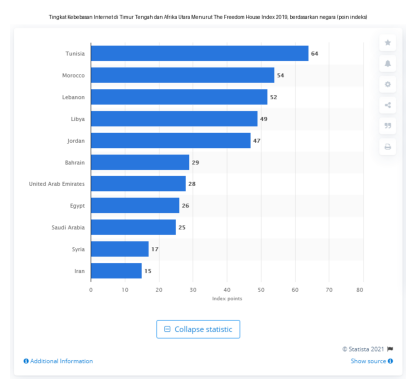

['\n Question: Buatkan deskripsi dari grafik berikut ini secara lengkap dan informatif Answer: Statistik ini menunjukkan negara-negara dengan tingkat kelebihan internasional terendah pada tahun 2019. Pada tahun 2019, Tunisia berada di peringkat pertama dengan tingkat kelebihan internasional 64 poin indeks. Tunisia adalah negara dengan tingkat kelebihan internasional tertinggi di Afrika Utara. Lebanon berada di peringkat kedua dengan tingkat kelebihan internasional 52 poin indeks. Lebanon adalah negara dengan tingkat kelebihan internasional tertinggi di Timur Tengah. Pada tahun 2019, Tunisia adalah negara dengan tingkat kelebihan internasional tertinggi di Afrika Utara. Tunisia adalah negara dengan tingkat kelebihan internasional tertinggi di Afrika Utara. Tunisia']


In [6]:
import matplotlib.pyplot as plt

plt.imshow(test_image)
plt.axis('off')  # Hilangkan axis
plt.show()

print(generated_texts)

In [7]:
# Ground truth answer
print(dataset["test"][sample_idx]['label'])

Statistik menunjukkan tingkat kebebasan internet di negara-negara Timur Tengah dan Afrika Utara tertentu. Menurut Indeks Freedom House, Suriah menduduki tempat terakhir dalam kebebasan internet dengan 86 poin indeks pada tahun 2019. Tunisia berada di peringkat pertama dengan 64 poin indeks.


In [8]:
# Load example
from PIL import Image
from io import BytesIO

sample_idx = 11
query = dataset["test"][sample_idx]['query']

test_image = Image.open(BytesIO(dataset["test"][sample_idx]['image'])).convert('RGB')
prompt = f"<image>\n Question: {query} Answer:"
inputs = processor(text=prompt, images=[test_image], return_tensors="pt").to("cuda")
inputs['pixel_values'] = inputs['pixel_values'].to(torch.float16)

# Generate token IDs. Change the max_new_tokens based on your task.
generated_ids = model.generate(**inputs, max_new_tokens=256)
# Decode back into text
generated_texts = processor.batch_decode(generated_ids, skip_special_tokens=True)

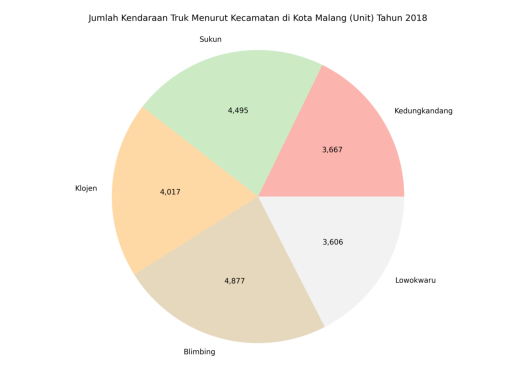

['\n Question: Buatkan deskripsi dari grafik berikut ini secara lengkap dan informatif Answer: Pada tahun 2018, jumlah kendaraan truk yang terdaftar di Kecamatan Kedungkandang adalah 3.667 unit, di Kecamatan Sukun sebanyak 4.495 unit, di Kecamatan Klojen sebanyak 4.017 unit, di Kecamatan Blimbing sebanyak 4.877 unit, dan di Kecamatan Lowokwaru sebanyak 3.606 unit. Kecamatan Blimbing tercatat sebagai wilayah dengan jumlah kendaraan truk terbanyak di Kota Malang, mencapai 4.877 unit, berbeda jauh dengan Kecamatan Lowokwaru yang hanya memiliki 3.606 unit. Kecamatan Sukun berada di peringkat kedua dengan 4.495 unit, sementara Kecamatan Kedungkandang berada di urutan ter']


In [9]:
import matplotlib.pyplot as plt

plt.imshow(test_image)
plt.axis('off')  # Hilangkan axis
plt.show()


print(generated_texts)

In [10]:
# Ground truth answer
print(dataset["test"][sample_idx]['label'])

Pada tahun 2018, Jumlah Kendaraan Truk di Kecamatan Kedungkandang sebanyak 3.667 unit, di Kecamatan Sukun sebanyak 4.495 unit, di Kecamatan Klojen sebanyak 4.017 unit, di Kecamatan Blimbing sebanyak 4.877 unit, dan di Kecamatan Lowokwaru sebanyak 3.606 unit. Dapat disimpulkan bahwa di Kota Malang, Kecamatan Blimbing unggul dengan Jumlah Kendaraan Truk terbanyak mencapai 4.877 Unit, berbanding terbalik dengan Kecamatan Lowokwaru yang hanya memiliki 3.606 Unit.


In [11]:
# Load example
from PIL import Image
from io import BytesIO

sample_idx = 111
query = dataset["test"][sample_idx]['query']

test_image = Image.open(BytesIO(dataset["test"][sample_idx]['image'])).convert('RGB')
prompt = f"<image>\n Question: {query} Answer:"
inputs = processor(text=prompt, images=[test_image], return_tensors="pt").to("cuda")
inputs['pixel_values'] = inputs['pixel_values'].to(torch.float16)

# Generate token IDs. Change the max_new_tokens based on your task.
generated_ids = model.generate(**inputs, max_new_tokens=256)
# Decode back into text
generated_texts = processor.batch_decode(generated_ids, skip_special_tokens=True)

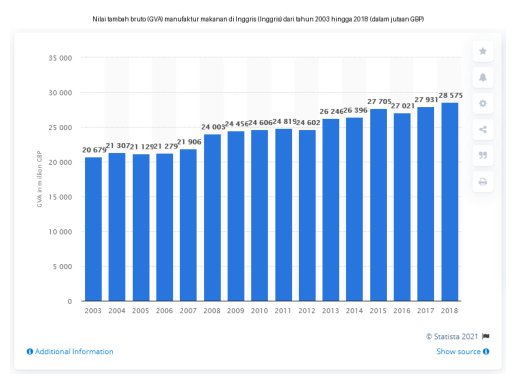

['\n Question: Buatkan deskripsi dari grafik berikut ini secara lengkap dan informatif Answer: Statistik ini menunjukkan nilai tambah bruto (GVA) dari industri makanan di Inggris (Inggris) dari tahun 2003 hingga 2018. Pada tahun 2018, nilai tambah bruto industri makanan Inggris berjumlah sekitar 28,57 miliar pound Inggris. Ini adalah peningkatan yang signifikan dari tahun sebelumnya, ketika nilai tambah bruto berjumlah 27,93 miliar pound Inggris. Industri makanan adalah salah satu sektor terbesar Inggris. Pada tahun 2018, industri makanan memiliki nilai tambah sekitar 28,57 miliar pound Inggris. Ini adalah peningkatan yang signifikan dari tahun sebelumnya, ketika nilai tambah bruto industri makanan Inggris berjumlah sek']


In [12]:
import matplotlib.pyplot as plt

plt.imshow(test_image)
plt.axis('off')  # Hilangkan axis
plt.show()

print(generated_texts)

In [13]:
# Ground truth answer
print(dataset["test"][sample_idx]['label'])

Statistik ini menunjukkan kontribusi manufaktur makanan terhadap total nilai tambah ekonomi bruto (GVA) di Inggris (Inggris) dari tahun 2003 hingga 2018. Pada tahun 2018, manufaktur makanan menyumbang sekitar 29 miliar pound Inggris untuk ekonomi nasional Inggris. Selain itu, statistik terpisah tentang nilai tambah bruto (GVA) dari grosir makanan dan ritel makanan di Inggris tersedia.


In [34]:
# Load example
from PIL import Image
from io import BytesIO

sample_idx = 2025
query = dataset["test"][sample_idx]['query']

test_image = Image.open(BytesIO(dataset["test"][sample_idx]['image'])).convert('RGB')
prompt = f"<image>\n Question: {query} Answer:"
inputs = processor(text=prompt, images=[test_image], return_tensors="pt").to("cuda")
inputs['pixel_values'] = inputs['pixel_values'].to(torch.float16)

# Generate token IDs. Change the max_new_tokens based on your task.
generated_ids = model.generate(**inputs, max_new_tokens=256)
# Decode back into text
generated_texts = processor.batch_decode(generated_ids, skip_special_tokens=True)

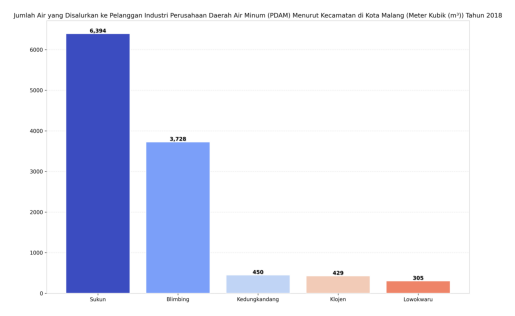

['\n Question: Buatkan deskripsi dari grafik berikut ini secara lengkap dan informatif Answer: Pada tahun 2018, jumlah air yang disalurkan kepada pelanggan industri oleh Perusahaan Daerah Air Minum (PDAM) di Kecamatan Kedungkandang tercatat sebanyak 450 mÂ³, di Kecamatan Sukun sebanyak 6.394 mÂ³, di Kecamatan Klojen sebanyak 429 mÂ³, di Kecamatan Blimbing sebanyak 3.728 mÂ³, dan di Kecamatan Lowokwaru sebanyak 305 mÂ³. Kecamatan Sukun mencatatkan angka tertinggi dalam hal air yang disalurkan ke pelanggan industri PDAM, yaitu sebesar 6.394 m³, sementara Kecamatan Lowokwaru menunjukkan angka terendah dengan 305 m³ di Kota Malang. Kecamatan Sukun memimpin dalam hal']


In [35]:
import matplotlib.pyplot as plt

plt.imshow(test_image)
plt.axis('off')  # Hilangkan axis
plt.show()

print(generated_texts)

In [36]:
# Ground truth answer
print(dataset["test"][sample_idx]['label'])

Tahun 2018 mencatat bahwa air yang dipasok untuk pelanggan industri Perusahaan Daerah Air Minum (PDAM) di Kecamatan Kedungkandang berjumlah 450 mÂ³, di Kecamatan Sukun mencapai 6.394 mÂ³, di Kecamatan Klojen sebesar 429 mÂ³, di Kecamatan Blimbing 3.728 mÂ³, dan di Kecamatan Lowokwaru 305 mÂ³. Kecamatan Sukun tercatat sebagai wilayah dengan volume pendistribusian air PDAM ke pelanggan industri paling besar, yakni sejumlah 6.394 m³, sementara Kecamatan Lowokwaru mencatatkan volume terendah sebesar 305 m³ di seluruh Kota Malang.
